# Optimization Project

In this Jupyter notebook, we will be using the Frank-Wolfe optimization algorithm to minimize the variance function of a portfolio in Markowitz's portfolio theory. Markowitz's theory focuses on optimizing investment portfolios by considering the trade-off between expected returns and risk. The variance function represents the risk component of the portfolio, and by minimizing it, we aim to find the optimal allocation of assets that balances risk and return. The Frank-Wolfe algorithm is an iterative optimization method that iteratively finds the direction of steepest descent to minimize the objective function. By applying this algorithm to the portfolio variance function, we can determine an efficient portfolio allocation that maximizes returns while minimizing risk. Let's dive into the details and explore the power of the Frank-Wolfe algorithm for portfolio optimization.

In [1]:
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy import hessian
import numdifftools as nd
import pandas as pd
import numpy as np
import scipy

In [2]:
PORTFOLIOS = ["EUROSTOXX_50", "FTSE_100", "MIBTEL_295", "SP_500", "NASDAQ"] 
PORTFOLIO = PORTFOLIOS[2] #CHANGE
RISK_AVERSION = 0.02

In [3]:
# Read the text file
name = pd.read_csv(PORTFOLIO+'/data/list.txt', delimiter='\t')
price_time = np.loadtxt(PORTFOLIO+'/data/price_time.txt', delimiter='\t')
ret_time = np.loadtxt(PORTFOLIO+'/data/Ret_time.txt', delimiter='\t')
ret_mean = np.loadtxt(PORTFOLIO+'/data/MRet.txt', delimiter='\t')
cov = np.loadtxt(PORTFOLIO+'/data/Cov.txt', delimiter='\t')
time = pd.read_csv(PORTFOLIO+'/data/time.txt', delimiter='\t')

# Solution
ret_risk = pd.read_csv(PORTFOLIO+'/solutions/RetRisk_SolVal.txt', delimiter='\t')

# Other variable
nStocks = len(name) + 1

## Portfolios Data

Portfolio: MIBTEL_295 
N. Stock: 226
From: 17-Mar-2003  To: 24-Mar-2008 


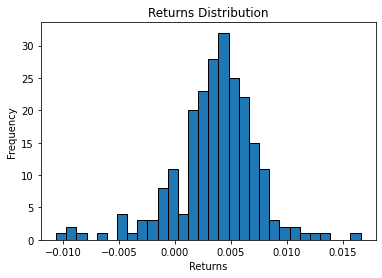

In [4]:
# Print Portfolio data
print(f"Portfolio: {PORTFOLIO} \nN. Stock: {nStocks}")
print(f"From: {time.iloc[0, 0]} To: {time.iloc[-1, 0]}")

plt.hist(ret_mean, bins=30, edgecolor='black')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Returns Distribution')
plt.show()

In [5]:
#Choose x1 in C
def generate_random_array(n):
    random_nums = np.random.rand(n)
    total = np.sum(random_nums)
    random_array = random_nums / total
    return random_array

e = np.ones((nStocks, 1))
weights = generate_random_array(nStocks)

print(f"B: {np.dot(e.T, weights)}")
print(sum(weights))
np.all(weights > 0)

B: [1.]
1.0000000000000009


True

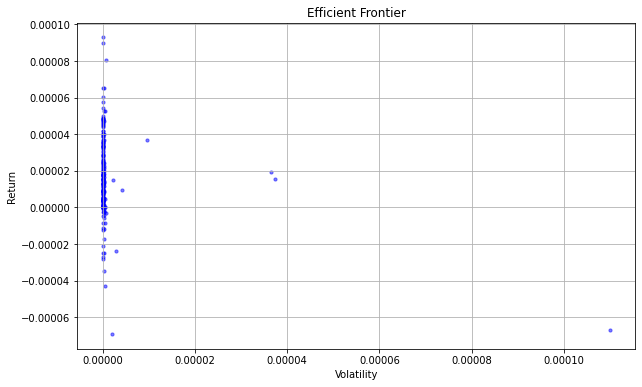

In [6]:
port_returns = []
port_volatility = []

for idx, w in enumerate(weights):
    port_returns.append(np.dot(w, ret_mean[idx]))

port_volatility = np.diag(np.dot(np.dot(cov, np.diag(weights)), cov.T))

plt.figure(figsize=(10, 6))
plt.scatter(port_volatility, port_returns, marker='o', color='b', s=10, alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.show()

# Portfolio Optimizations

We have $n$ avaiable assets. We call $w_i$ the quantity of money invested on the
$i$-th asset during the considered period and with $r_i$ the returns on the $i$-th
asset. We have two different constraints. The first one is non-negativity for the
variables (i.e., $w_i$ ≥ 0). It basically means that short selling (selling asset that
we still don’t own) is not allowed. We then have the budget constraint:

$
\begin{equation}
\sum_{i=1}^{n} w_i = B
\end{equation}
$



the total amount of money invested needs to be equal to the budget $B$ ($B$ can be simply set to 1).
Consider a stochastic model for the returns: $r ∈ R^n$ is a randomly generated vector with mean $\overline{r}$ and covariance $\Sigma$. Thus expected return will be:
$
\begin{equation}
\overline{r}^\intercal \, w
\end{equation}
$
and variance (risk)
$
\begin{equation}
w^\intercal \, \Sigma \, w
\end{equation}
$
Classic portfolio problem, described by Markowitz (1952), is a convex quadratic programming problem:
$
\begin{equation}
\begin{split}
\underset{w∈R^n}{min} \quad \gamma \, w^\intercal \, \Sigma \, w - \overline{r}^\intercal \, w \\
s.t. \quad e^\intercal w = 1 \\
w > 0
\end{split}
\end{equation} 
$
with $\gamma$ > 0 risk-aversion parameter. Goal is thus finding the set of assets that
minimizes the variance (risk connected to the given portfolio) while maximizing
the expected return (we obviously need to satisfy budget and non-negativity
constraints).

In [7]:
def checkMinRet(weights):
    return np.dot(ret_mean.T, weights)

def checkSumOne(weights):
    return np.sum(weights) - 1

In [8]:
def riskFunction(weights):
    return np.dot(w.T, np.dot(cov, weights))

def loss(weights):
    return RISK_AVERSION * np.dot(weights.T, np.dot(cov, weights)) - np.dot(ret_mean.T, weights)

### Hessian and Lipschitz constant
Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.

In [9]:
def lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
    
def is_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

In [10]:
%%time
print("Hessian matrix")
hessian = nd.Hessian(loss)(weights)

print("Calculating sigma (strongly convex)")
sigma = is_strongly_convex(hessian)
is_sc = sigma > 0

if is_sc: print(f"Sigma: {sigma}, strongly convex")
else: print(f"Sigma: {sigma}, not strongly convex")

L = lipschitz_constant(hessian)
print(f"Lipschitz constant: {L}")

print("Lipschitz constant for single variable")
Li = np.repeat(L, len(hessian))

Hessian matrix
Calculating sigma (strongly convex)
Sigma: -7.325283316591871e-15, not strongly convex
Lipschitz constant: 0.004971788705017177
Lipschitz constant for single variable
CPU times: user 2min 51s, sys: 1.86 s, total: 2min 52s
Wall time: 23 s


## Projected Gradient Descent

$
\begin{equation}
\nabla f(w_k) = 2 \, \gamma \, \Sigma \, w - \overline{r}^\intercal\\
\end{equation} 
$

In [11]:
def gradient(w):
    return RISK_AVERSION * 2 * np.dot(cov, w) - ret_mean

In [12]:
from scipy.optimize import minimize

bounds = tuple([(0, 1) for _ in range(nStocks)])
constraints = ( {'type':'eq', 'fun': checkMinRet}, {'type':'eq', 'fun': checkSumOne} )

w_opt = minimize(loss, weights, method="SLSQP", bounds=bounds, constraints=constraints)

In [13]:
sum(w_opt.x)

1.0

Frank Wolfe, Pairwise Frank Wolfe and Projected Gradient over the Markowitz portfolio problems

## Frank-Wolfe Method

In [14]:
def linear_solver(grad):
    c = -grad
    A_eq = np.ones((1, nStocks))
    b_eq = np.array([1])
    bounds = [(0, 1) for _ in range(nStocks)]
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='simplex')
    return res.x

def duality_gap(weights, grad):
    """
    Compute the duality gap for the given weights and gradient.
    """
    s = linear_solver(grad)
    return np.dot(grad, weights - s)

In [20]:
ITERATIONS = 100

# Lists to store values for plotting
objective_values = []
duality_gaps = []
gradient_norms = []

weights = generate_random_array(nStocks)
prev_loss = float('inf')

for itr in range(0, ITERATIONS):
    grad = gradient(weights)
    s = linear_solver(grad)
    direction = s - weights

    # Compute duality gap
    gap = duality_gap(weights, grad)
    print(gap)

    # Store values for plotting
    objective_values.append(loss(weights))
    duality_gaps.append(gap)
    gradient_norms.append(np.linalg.norm(grad))
    
    if gap >= -1e-6:
        print("Stopping due to small duality gap.")
        break
    
    # Line search to find the optimal step size
    step_size = 1
    for i in range(100):
        weights_new = weights + step_size * direction
        if loss(weights_new) < loss(weights):
            break
        step_size /= 2
    
    weights_new /= np.sum(weights_new) # Normalizing the updated weights

    current_loss = loss(weights_new)
    
    #norm_update = np.linalg.norm(weights_new - weights)
    #if norm_update < 1e-6 or abs(prev_loss - current_loss) < 1e-6:
    #    print('break')
    #    break
    
    weights = weights_new
    prev_loss = current_loss


/var/folders/wx/4rpnc78s6nj_ttkmd4gcb2qr0000gn/T/ipykernel_42980/2317439667.py:6: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='simplex')


-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.01415434907878489
-0.0141543490

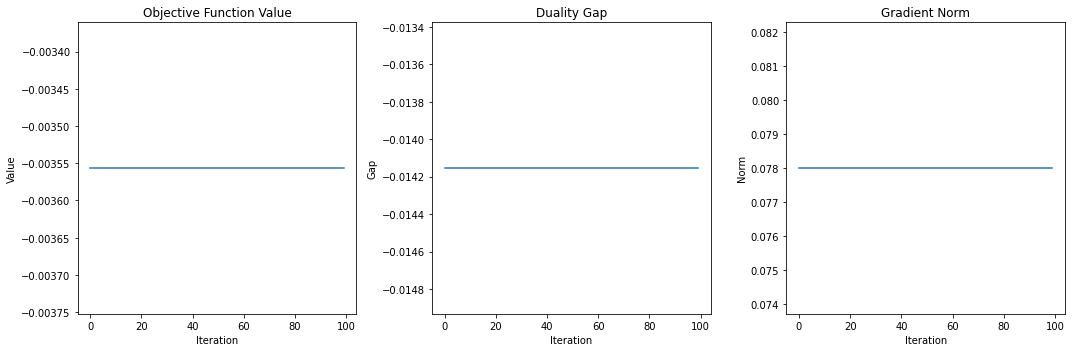

Final weights: (226,)
Sum of weights: 1.0
Return Portfolio:  0.0035608765920597807


In [21]:
# Plotting the metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(objective_values)
plt.title('Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 3, 2)
plt.plot(duality_gaps)
plt.title('Duality Gap')
plt.xlabel('Iteration')
plt.ylabel('Gap')

plt.subplot(1, 3, 3)
plt.plot(gradient_norms)
plt.title('Gradient Norm')
plt.xlabel('Iteration')
plt.ylabel('Norm')

plt.tight_layout()
plt.show()

print("Final weights:", weights.shape)
print("Sum of weights:", np.sum(weights))
print('Return Portfolio: ', checkMinRet(weights))

## Pairwise Frank-Wolfe

In [17]:
def pairwise_fw_update(grad, w):
    """
    Compute the Pairwise Frank-Wolfe direction.
    """
    # Identifying the two components of the gradient to modify
    i = np.argmax(grad)
    j = np.argmin(grad)
    
    # Constructing the direction vector
    d = np.zeros_like(grad)
    d[i] = -w[i]
    d[j] = 1-w[j]
    
    return d


In [18]:
# Initialize weights and other parameters
weights = generate_random_array(nStocks)
prev_loss = float('inf')

for itr in range(0, ITERATIONS):
    grad = gradient(weights)
    direction = pairwise_fw_update(grad, weights)
    
    # Line search (similar to your previous implementation)
    step_size = 1
    for i in range(100):
        weights_new = weights + step_size * direction
        if loss(weights_new) < loss(weights):
            break
        step_size /= 2
    
    weights_new /= np.sum(weights_new) # Normalizing the updated weights
    
    current_loss = loss(weights_new)
    
    norm_update = np.linalg.norm(weights_new - weights)
    if norm_update < 1e-6 or abs(prev_loss - current_loss) < 1e-6:
        print('break')
        break
    
    weights = weights_new
    prev_loss = current_loss

In [19]:
print("Final weights:", weights.shape)
print("Sum of weights:", np.sum(weights))
print('Return Portfolio: ', checkMinRet(weights))

Final weights: (226,)
Sum of weights: 0.9999999999999999
Return Portfolio:  0.01644701876580538
